# Interpretability and Explainability | Grad-CAM

This demo demonstrates how to use the **gradient-weighted class activation mapping (Grad-CAM)** [1] to visualize the CNN's saliency map for the classification task. 

![Demo Figure](Util/demo1_1.jpg)

[1] Selvaraju, Ramprasaath R., et al. "Grad-CAM: Visual explanations from deep networks via gradient-based localization." Proceedings of the IEEE international conference on computer vision. 2017.

### Step 1: Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

### Step 2: Load a Pretrained Model and Input Image 

/Users/scarlettdu/CS/anacondasiyi/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


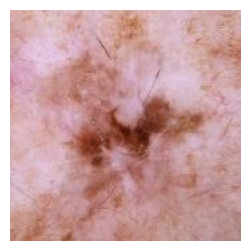

In [2]:
# Load a pretrained model
model = models.resnet18(pretrained=True)

# Load and preprocess the image
def load_and_preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    tensor = preprocess(image).unsqueeze(0)
    return tensor, image

image_path = "Sample/001.jpg"  # Replace with your image path
input_tensor, original_image = load_and_preprocess_image(image_path)

# Visualize the original image
plt.figure(figsize=(3, 3))
plt.imshow(original_image)
plt.axis("off")
plt.show()

### Step 3: Forward Pass and Get Predictions

In [3]:
# Forward pass through the model
output = model(input_tensor)
predicted_class = torch.argmax(output, dim=1).item()
print(f"Predicted class index: {predicted_class}")

Predicted class index: 463


### Step 4: Define Grad-CAM

<img src="Util/demo1_2.jpg" alt="grad-cam process" width="600"/>

To obtain the class-discriminative localization map Grad-CAM $L^c_{Grad-CAM}$ for any class $c$, we need to

1. Calculate the neuron importance weights $\delta_k^c$ of $k$-th feature map $A^k$
$$
\delta_k^c = \overset{\text{global average pooling}}{\overbrace{\frac{1}{Z}\sum_i\sum_j}} \underset{\text{gradients via back propagation}}{\underbrace{\frac{\partial y^c}{\partial A^k_{ij}}}} \tag{1}
$$

2. Perform a weighted combination of forward activation maps, and follow it by a ReLU
$$
L^c_{Grad-CAM} = \operatorname{ReLU} \underset{\text{linear combination}}{\underbrace{(\sum_k \delta^c_k A^k)}} \tag{2}
$$

In [4]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class):
        # Forward pass
        output = self.model(input_tensor)

        # Backward pass
        self.model.zero_grad()
        target = output[0, target_class]
        target.backward()

        # Compute Grad-CAM
        # Eq (1)
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        # Eq (2)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = torch.relu(cam)

        # Normalize the CAM
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam.detach().cpu().numpy()

### Step 5: Apply Grad-CAM

In [18]:
# Select the target layer and initialize Grad-CAM
target_layer = model.layer4[1].conv2  # Example target layer
grad_cam = GradCAM(model, target_layer)

# Generate Grad-CAM
cam = grad_cam.generate(input_tensor, predicted_class)

### Step 6: Visualize the results

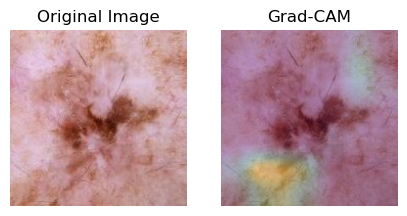

In [38]:
def overlay_heatmap_on_image(heatmap, original_image, alpha=0.6, colormap="viridis"):
    # Resize heatmap to match original image
    heatmap = np.uint8(heatmap * 255)
    heatmap_resized = Image.fromarray(heatmap).resize(original_image.size, resample=Image.Resampling.BICUBIC)

    # Apply colormap
    colormap = plt.get_cmap(colormap)
    colored_heatmap = colormap(np.array(heatmap_resized) / 255.0)[:, :, :3]  # Remove alpha channel

    # Overlay heatmap on the image
    overlay = alpha * colored_heatmap + (1 - alpha) * np.array(original_image) / 255
    return np.uint8(255 * overlay)


# Display the results
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

overlayed_image = overlay_heatmap_on_image(cam, original_image)

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(original_image)
plt.imshow(overlayed_image, cmap='jet', alpha=0.5)  # Overlay the heatmap
plt.axis('off')
plt.show()